# 1) The Problem

We have set out to build a Recurrent Neural Network to predict if a question is true or false based on a small passage regarding the topic.

# Preformance Metrics

Their baseline was 80.4% after the creation of a new algorithm. There was a 90% accuracy when humans labeled the questions with their respective true or false answers. The majority-baseline was 62%. This means that instead of having a 50/50 split on their data, they had a 62/38 split. 

# Why is this important?

With more and more companies moving to an automated chat bot style of customer service, the accuracy with which a computer can answer questions is paramount.

#  2) Collection/Discussion of Data

Our data came from https://github.com/google-research-datasets/boolean-questions. All of the questions are true or false. This data set was used in a research paper from Google employees published in 2019.

# 3) Data Analysis

# Code

In [3]:
#Imports for path models and nlp pipeline.
import os
import random
import re
import jsonlines
import numpy as np
import pickle
import tensorflow as tf
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack,vstack
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Concatenate, Dense, Dropout, LSTM, Bidirectional
from tensorflow.keras.activations import relu
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, plot_confusion_matrix
import itertools
import matplotlib.pyplot as plt

In [5]:
#Pulls random indecies to print.
def getRandomIndecies(desired_range, n_indecies=5):
    randoms = list()
    for x in range(n_indecies):
        randoms.append(random.randint(0,desired_range))
    return randoms

Path for text.

In [9]:
qa_path = os.path.join(os.getcwd())

Pulls all text from files into an array of questions, titles, answers, and passages.

In [10]:
qa_array = list()

qa_file = open(os.path.join(qa_path,"train.jsonl"), encoding="utf-8")
for line in qa_file.readlines():
    qa_array.append(line)
qa_file.close()

qa_file = open(os.path.join(qa_path,"dev.jsonl"), encoding="utf-8")
for line in qa_file.readlines():
    qa_array.append(line)
qa_file.close()

Prints datapoint to see amount of data and analyze the text.

In [11]:
print("Datapoints:",len(qa_array),'\n')
for index in getRandomIndecies(len(qa_array)):
    print(qa_array[index],'\n')

Datapoints: 12697 

{"question": "is there a vacuum in a vacuum cleaner", "title": "Vacuum cleaner", "answer": "true", "passage": "A vacuum cleaner, also known as a sweeper or hoover, is a device that uses an air pump (a centrifugal fan in all but some of the very oldest models), to create a partial vacuum to suck up dust and dirt, usually from floors, and from other surfaces such as upholstery and draperies."}
 

{"question": "does the speaker of the house have to be a congressman", "title": "Speaker of the United States House of Representatives", "answer": "false", "passage": "The Constitution does not require the Speaker to be an elected member of the House of Representatives, although every Speaker thus far has been. The Speaker is second in the United States presidential line of succession, after the Vice President and ahead of the President pro tempore of the Senate."}
 

{"question": "is chewing tobacco banned in major league baseball", "title": "Tobacco usage in sport", "answer

# 4A) Preprocessing

## Sequence

Title is redudant so we only extract the question, answer and passage. 
Extracts question, passage, and answer from the text.

In [12]:

qap_array = list()

for qa in qa_array:
    sections = re.findall(r'"([^"]*)"', qa)
    qap = ()
    for x,section in enumerate(sections):
        if(section == "question" or section == "answer" or section == "passage"):
            qap = qap + (sections[x+1].lower(),)
    qap_array.append(qap)

Prints the seperated question, answer and passage.

In [13]:
print("QAP's:",len(qap_array),'\n')
for index in getRandomIndecies(len(qap_array)):
    print(qap_array[index],'\n')

QAP's: 12697 

('does the whole nba team get a ring', 'true', "the nba championship ring is an annual award given by the national basketball association to the team that wins the nba finals. rings are presented to the team's players, coaches, and members of the executive front office. red auerbach has the most rings overall with 16. phil jackson has the most as coach and bill russell has the most as a player (11 each)") 

('can you use coarse salt in a dishwasher', 'true', "in some countries, especially those in europe, dishwashers include a built-in water softener that removes calcium and magnesium ions from the water. dishwasher salt, which is coarse-grained sodium chloride (table salt), is used to regenerate the resin in the built-in ion-exchange system. the coarse grains prevent it from clogging the softener unit. unlike certain types of salt used for culinary purposes, it does not contain added anticaking agents or magnesium salts. the presence of magnesium salts will defeat the p

Creates a pickle object file of the qap's.

In [14]:
try:
    qap_location = os.mkdir(os.path.join(os.getcwd(),"Preprocessed_Text"))
except OSError:
    None

qap_location = os.path.join(os.getcwd(), "Preprocessed_text", "preprocessed_text")    

file = open(qap_location, "wb")
    
pickle.dump(qap_array,file)

file.close()

Loads in the pickle object and splits the sections into questions, answers, passage.

In [15]:
questions = list()
answers = list()
passages = list()

file = open(qap_location, "rb")

for item in pickle.load(file):
    questions.append(item[0])
    answers.append(item[1])
    passages.append(item[2])

Ratio of true/false.

In [16]:
counter = 0
for item in answers:
    if(item == 'true'):
        counter += 1

print((counter/len(qa_array))*100)

62.27455304402615


Print seperate questions, answers, and passages.

In [17]:
indecies = getRandomIndecies(len(qap_array))

Question

In [18]:
for index in indecies:
    print(questions[index],'\n')

is 9 to 5 a 40 hour week 

has washington capitals ever won the stanley cup 

is it legal to shoot camels in australia 

is it ordinary time in the catholic church 

is a markup language designed to describe data 



Answer

In [19]:
for index in indecies:
    print(answers[index],'\n')

true 

true 

true 

true 

false 



Passage

In [20]:
for index in indecies:
    print(passages[index],'\n')

the traditional american business hours are 9:00 a.m. to 5:00 p.m., monday to friday, representing a workweek of five eight-hour days comprising 40 hours in total. these are the origin of the phrase 9-to-5, used to describe a conventional and possibly tedious job. negatively used, it connotes a tedious or unremarkable occupation. the phrase also indicates that a person is an employee, usually in a large company, rather than an entrepreneur or self-employed. more neutrally, it connotes a job with stable hours and low career risk, but still a position of subordinate employment. the actual time at work often varies between 35 and 48 hours in practice due to the inclusion, or lack of inclusion, of breaks. in many traditional white collar positions, employees were required to be in the office during these hours to take orders from the bosses, hence the relationship between this phrase and subordination. workplace hours have become more flexible, but the phrase is still commonly used. 

the 

## Tokenize

Splits questions and passages into word tokens on the space.

In [21]:
def tokenize(lst):
    tokenized_list = list()
    
    for item in lst:
        sequence = list()
        temp = item.split()
        for token in temp:
            sequence.append(token)
        tokenized_list.append(sequence)
        
    return tokenized_list

In [22]:
qtokenized = tokenize(questions)
ptokenized = tokenize(passages)
print("Question\n", qtokenized[0])
print("Passage\n", ptokenized[0])

Question
 ['do', 'iran', 'and', 'afghanistan', 'speak', 'the', 'same', 'language']
Passage
 ['persian', '(/ˈpɜːrʒən,', '-ʃən/),', 'also', 'known', 'by', 'its', 'endonym', 'farsi', '(فارسی', 'fārsi', '(fɒːɾˈsiː)', '(', 'listen)),', 'is', 'one', 'of', 'the', 'western', 'iranian', 'languages', 'within', 'the', 'indo-iranian', 'branch', 'of', 'the', 'indo-european', 'language', 'family.', 'it', 'is', 'primarily', 'spoken', 'in', 'iran,', 'afghanistan', '(officially', 'known', 'as', 'dari', 'since', '1958),', 'and', 'tajikistan', '(officially', 'known', 'as', 'tajiki', 'since', 'the', 'soviet', 'era),', 'and', 'some', 'other', 'regions', 'which', 'historically', 'were', 'persianate', 'societies', 'and', 'considered', 'part', 'of', 'greater', 'iran.', 'it', 'is', 'written', 'in', 'the', 'persian', 'alphabet,', 'a', 'modified', 'variant', 'of', 'the', 'arabic', 'script,', 'which', 'itself', 'evolved', 'from', 'the', 'aramaic', 'alphabet.']


Verify lengths

In [23]:

print(len(qtokenized))
print(len(ptokenized))

12697
12697


Cleans tokens of punctuations and splits hyphenated words.

In [24]:
def cleanTokens(lst):
    
    punctuations = ['\'','!','(',')','[',']','{','}',';',':','"','\\',',','<','>','.','/','?','@','#','$','%','^','&','*','_','~','`']
    hyphen = ['-']
    clean_lst = list()
    for item in lst:
        tokens = list()
        for token in item:
            token_string = ""
            for char in token:
                if(char not in punctuations and char != '-'):
                    token_string = token_string + char
                elif(char in hyphen):
                    tokens.append(token_string)
                    token_string = ""
            tokens.append(token_string)
        clean_lst.append(tokens)
    
    return clean_lst

In [25]:
qtokenized_clean = cleanTokens(qtokenized)
ptokenized_clean = cleanTokens(ptokenized)
print("Question\n", qtokenized_clean[0])
print("Passage\n", ptokenized_clean[0])

Question
 ['do', 'iran', 'and', 'afghanistan', 'speak', 'the', 'same', 'language']
Passage
 ['persian', 'ˈpɜːrʒən', '', 'ʃən', 'also', 'known', 'by', 'its', 'endonym', 'farsi', 'فارسی', 'fārsi', 'fɒːɾˈsiː', '', 'listen', 'is', 'one', 'of', 'the', 'western', 'iranian', 'languages', 'within', 'the', 'indo', 'iranian', 'branch', 'of', 'the', 'indo', 'european', 'language', 'family', 'it', 'is', 'primarily', 'spoken', 'in', 'iran', 'afghanistan', 'officially', 'known', 'as', 'dari', 'since', '1958', 'and', 'tajikistan', 'officially', 'known', 'as', 'tajiki', 'since', 'the', 'soviet', 'era', 'and', 'some', 'other', 'regions', 'which', 'historically', 'were', 'persianate', 'societies', 'and', 'considered', 'part', 'of', 'greater', 'iran', 'it', 'is', 'written', 'in', 'the', 'persian', 'alphabet', 'a', 'modified', 'variant', 'of', 'the', 'arabic', 'script', 'which', 'itself', 'evolved', 'from', 'the', 'aramaic', 'alphabet']


Verify lengths

In [26]:
print(len(qtokenized_clean))
print(len(ptokenized_clean))

12697
12697


## Create Vocabulary

Creates a vocabulary from the words in the token list.

In [27]:
def getVocab(lst):
    
    vocab = dict()
    
    for text in lst:
        for token in text:
            if(vocab.get(token,"") == ""):
                vocab.update({token : 1})
            else:
                vocab[token] = vocab[token]+1
                
    return vocab

In [28]:
qvocab = getVocab(qtokenized_clean)
pvocab = getVocab(ptokenized_clean)
print("Words in questions vocab:",len(qvocab))
print("Words in passages vocab:",len(pvocab))

Words in questions vocab: 10507
Words in passages vocab: 50673


Retreives statistics from the vocab(average appearance, most common, least common). Prints all vocabulary and their appearances.

In [33]:
def vocabStats(vocab,whole_vocab=False):
    
    vocab_array = list()
    
    minimum = ("",1000000000)
    maximum = ("",0)
    avg = 0 
    stnd = 0 
    
    for word in vocab:
        if(whole_vocab == True):
            #print(word, vocab[word])
        if(vocab[word] > maximum[1]):
            maximum = (word,vocab[word])
        if(vocab[word] < minimum[1]):
            minimum = (word,vocab[word])
        vocab_array.append(vocab[word])
        
    avg = np.mean(vocab_array)
    stnd = np.std(vocab_array)
    
    print("Min count:", minimum, "Max count:", maximum, "Average appearance:", avg, "Standard Deviation:", stnd)
    return vocab,avg,stnd

In [35]:
qvocab, qavg, qstnd = vocabStats(qvocab,True)

Min count: ('iran', 1) Max count: ('the', 8578) Average appearance: 10.629389930522509 Standard Deviation: 136.62667831924844


In [36]:
pvocab, pavg,  pstnd = vocabStats(pvocab,True)

Min count: ('ˈpɜːrʒən', 1) Max count: ('the', 88883) Average appearance: 23.626980837921575 Standard Deviation: 535.5165576945782


# 4B) Feature Engineering

Removes words that appear to frequent with in n_deviations.

In [28]:
def removeErroneousVocab(vocab,avg,stnd,n_deviations=3):
    
    upper = avg + stnd*n_deviations
    erroneous_words = list()
    
    for word in vocab:
        if(vocab[word] >= upper):
            erroneous_words.append(word)
    
    for x in range(len(erroneous_words)):
        del vocab[erroneous_words[x]]

    return vocabStats(vocab)

In [29]:
qvocab, qavg, qstnd = removeErroneousVocab(qvocab, qavg, qstnd)

Min count: ('iran', 1) Max count: ('based', 380) Average appearance: 5.872494750906662 Standard Deviation: 18.84523128594015


In [30]:
pvocab, pavg, pstnd = removeErroneousVocab(pvocab, pavg, pstnd)

Min count: ('ˈpɜːrʒən', 1) Max count: ('such', 1622) Average appearance: 14.358702309683283 Standard Deviation: 59.40000367207913


Words in vocabularies.

In [31]:
print(len(qvocab))
print(len(pvocab))

10478
50613


Creates one vocabulary by appending words not in the larger from the smaller.

In [32]:
def unifyVocab(avocab, bvocab):
    large_vocab = avocab if len(avocab) > len(bvocab) else bvocab
    small_vocab = bvocab if len(bvocab) < len(large_vocab) else avocab
    for word in small_vocab:
        if(large_vocab.get(word,"") == ""):
            large_vocab.update({word : small_vocab[word]})
        
    return large_vocab

In [33]:
vocab = unifyVocab(qvocab, pvocab)

Total vocabulary

In [34]:
print(len(vocab))

51162


Removes words in tokenized sequences that are no longer in the vocabulary.

In [35]:
def fitVocab(lst,vocab):
    tokenized_list = list()
    
    for item in lst:
        sequence = list()
        for token in item:
            if(vocab.get(token,"") != ""):
                sequence.append(token)
        tokenized_list.append(sequence)
        
    return tokenized_list

In [36]:
qvocab_tokens = fitVocab(qtokenized_clean,vocab)
pvocab_tokens = fitVocab(ptokenized_clean,vocab)
print("Question\n", qvocab_tokens[:5])
print("Passage\n", pvocab_tokens[:5])

Question
 [['do', 'iran', 'afghanistan', 'speak', 'same', 'language'], ['do', 'good', 'samaritan', 'laws', 'protect', 'those', 'who', 'help', 'at', 'accident'], ['windows', 'movie', 'maker', 'part', 'windows', 'essentials'], ['confectionary', 'sugar', 'same', 'powdered', 'sugar'], ['elder', 'scrolls', 'online', 'same', 'skyrim']]
Passage
 [['persian', 'ˈpɜːrʒən', '', 'ʃən', 'also', 'known', 'by', 'its', 'endonym', 'farsi', 'فارسی', 'fārsi', 'fɒːɾˈsiː', '', 'listen', 'one', 'western', 'iranian', 'languages', 'within', 'indo', 'iranian', 'branch', 'indo', 'european', 'language', 'family', 'primarily', 'spoken', 'iran', 'afghanistan', 'officially', 'known', 'dari', 'since', '1958', 'tajikistan', 'officially', 'known', 'tajiki', 'since', 'soviet', 'era', 'some', 'other', 'regions', 'which', 'historically', 'were', 'persianate', 'societies', 'considered', 'part', 'greater', 'iran', 'written', 'persian', 'alphabet', 'modified', 'variant', 'arabic', 'script', 'which', 'itself', 'evolved', 'fr

Verify lengths

In [37]:
print(len(qvocab_tokens))
print(len(pvocab_tokens))

12697
12697


Retreives statistics on lengths of tokenized sequences.

In [38]:
def sequenceLenStats(sequences,quantile_ranges=[0.0,0.25,0.50,0.75,1.0]):
    avg = 0
    sequence_lens = list()
    
    for sequence in sequences:
        avg += len(sequence)
        sequence_lens.append(len(sequence))
    
    avg = avg/len(sequences)
    print("Avg:", avg)

    print("Quantiles:", np.quantile(sequence_lens,quantile_ranges))

In [39]:
sequenceLenStats(qvocab_tokens)
sequenceLenStats(pvocab_tokens)

Avg: 5.560919902339135
Quantiles: [ 3.  5.  5.  6. 15.]
Avg: 67.45766716547216
Quantiles: [  3.  40.  60.  85. 562.]


In [40]:
sequenceLenStats(qvocab_tokens,[0.80, 0.85, 0.90, 0.95, 1.0])
sequenceLenStats(pvocab_tokens,[0.80, 0.85, 0.90, 0.95, 1.0])

Avg: 5.560919902339135
Quantiles: [ 6.  7.  7.  8. 15.]
Avg: 67.45766716547216
Quantiles: [ 92. 102. 115. 140. 562.]


Truncates and pads sequences to a uniform lenght.

In [41]:
def padSequences(sequences,pad_size):
    
    even_sequences = list()
    
    for x,sequence in enumerate(sequences):
        if(len(sequence) >= pad_size):
            even_sequences.append(sequence[:pad_size])
        elif (len(sequence) < pad_size):
            amount_padding = pad_size - len(sequence)
            padding = list()
            for x in range(amount_padding):
                padding.append("%PAD%")
            even_sequences.append(sequence + padding)
        
    return even_sequences

In [42]:
qpadded = padSequences(qvocab_tokens,15)
ppadded = padSequences(pvocab_tokens, 115)
print(qpadded[7])
print(ppadded[7])

['federal', 'court', 'same', 'supreme', 'court', '%PAD%', '%PAD%', '%PAD%', '%PAD%', '%PAD%', '%PAD%', '%PAD%', '%PAD%', '%PAD%', '%PAD%']
['federal', 'courts', 'composed', 'three', 'levels', 'courts', 'supreme', 'court', 'united', 'states', 'court', 'last', 'resort', 'generally', 'appellate', 'court', 'that', 'operates', 'under', 'discretionary', 'review', 'which', 'means', 'that', 'court', 'choose', 'which', 'cases', 'hear', 'by', 'granting', 'writs', 'certiorari', 'there', 'therefore', 'generally', 'no', 'basic', 'right', 'appeal', 'that', 'extends', 'automatically', 'all', 'way', 'supreme', 'court', 'few', 'situations', 'like', 'lawsuits', 'between', 'state', 'governments', 'or', 'some', 'cases', 'between', 'federal', 'government', 'state', 'sits', 'court', 'original', 'jurisdiction', '%PAD%', '%PAD%', '%PAD%', '%PAD%', '%PAD%', '%PAD%', '%PAD%', '%PAD%', '%PAD%', '%PAD%', '%PAD%', '%PAD%', '%PAD%', '%PAD%', '%PAD%', '%PAD%', '%PAD%', '%PAD%', '%PAD%', '%PAD%', '%PAD%', '%PAD%', '%

Verify lengths

In [43]:
print(len(qpadded))
print(len(ppadded))

12697
12697


## Vectorize

From a custom glove file token vector representations are collected, vectors are 300D.

In [44]:
glove_path = os.path.join(os.getcwd(),"newGlove.txt")

embeddings = {}

with open(glove_path, 'r', encoding="utf-8") as file:
        for line in file:
            embedding = line[:-1].split(' ')
            token = embedding[0].lower()
            vector = [float(number) for number in embedding[1:]]
            embeddings.update({token : vector})

print(len(embeddings))
print(len(embeddings['based']))

47787
300


Removes words that have no glove vector.

In [45]:
def removeOOV(vocb,embedding_vocb):
    OOVs = list()
    for word in vocb:
        if(embedding_vocb.get(word,"") == ""):
            OOVs.append(word)
    file = open(os.path.join(os.getcwd(),"words.txt"), 'w', encoding="utf-8")
    for word in OOVs:
        file.write(word + '\n')
        del vocb[word]

In [46]:
removeOOV(vocab,embeddings)

New length of vocab.

In [47]:
print(len(vocab))

46160


Creates a dictornay mapping vocab to token vectors.

In [48]:
def embedVocab(vocb,embedding_vocb):
    embedded_vocab = dict()
    
    for word in vocb:
        if(embedding_vocb.get(word,"") != ""):
            embedded_vocab.update({word : embedding_vocb[word]})
    
    return embedded_vocab

In [50]:
embedded_vocab = embedVocab(vocab,embeddings)

Adds padding token to vocab.

In [51]:
embedded_vocab.update({"%PAD%" : []})

Removes any tokens that are not in the vectorized vocab.

In [52]:
def OOVToken(token_list,emb_vocb):
    full_tokenized = list()
    for item in token_list:
        items = list()
        for x,token in enumerate(item):
            if(emb_vocb.get(token,"") == ""):
                items.append("%OOV%")
            else:
                items.append(token)
        full_tokenized.append(items)
        
    return full_tokenized

In [53]:
qfull_tokenized = OOVToken(qpadded,embedded_vocab)
pfull_tokenized = OOVToken(ppadded,embedded_vocab)
print(qfull_tokenized[0])
print(pfull_tokenized[0])

['do', 'iran', 'afghanistan', 'speak', 'same', 'language', '%PAD%', '%PAD%', '%PAD%', '%PAD%', '%PAD%', '%PAD%', '%PAD%', '%PAD%', '%PAD%']
['persian', '%OOV%', '%OOV%', 'ʃən', 'also', 'known', 'by', 'its', 'endonym', 'farsi', '%OOV%', '%OOV%', '%OOV%', '%OOV%', 'listen', 'one', 'western', 'iranian', 'languages', 'within', '%OOV%', 'iranian', 'branch', '%OOV%', 'european', 'language', 'family', 'primarily', 'spoken', 'iran', 'afghanistan', 'officially', 'known', 'dari', 'since', '1958', 'tajikistan', 'officially', 'known', 'tajiki', 'since', 'soviet', 'era', 'some', 'other', 'regions', 'which', 'historically', 'were', 'persianate', 'societies', 'considered', 'part', 'greater', 'iran', 'written', 'persian', 'alphabet', 'modified', 'variant', 'arabic', 'script', 'which', 'itself', 'evolved', 'from', 'aramaic', 'alphabet', '%PAD%', '%PAD%', '%PAD%', '%PAD%', '%PAD%', '%PAD%', '%PAD%', '%PAD%', '%PAD%', '%PAD%', '%PAD%', '%PAD%', '%PAD%', '%PAD%', '%PAD%', '%PAD%', '%PAD%', '%PAD%', '%PAD%

Removes padding from vectorized vocab.

In [54]:
del embedded_vocab["%PAD%"]

Verify lengths

In [55]:
print(len(qfull_tokenized))
print(len(pfull_tokenized))

12697
12697


Creates a token to index encoder and decoder.

In [56]:
def getEnDecoder(vocab):
    encode = {}
    encode.update({"%PAD%" : 0})
    encode.update({"%OOV%" : 1})
    
    decode = {}
    decode.update({0 :"%PAD%"})
    decode.update({1 :"%OOV%"})
    
    counter = 2
    
    for token in vocab:
        if(vocab.get(token,"") != ""):
            encode.update({token : counter})
            decode.update({counter : token})
            counter = counter + 1
            
    return encode,decode

In [57]:
encoder, decoder = getEnDecoder(embedded_vocab)
print(encoder['persian'])

2


Encodes the tokens to an index.

In [58]:
def encode(token_list,token_encode):
    encoded_tokens = list()
    for item in token_list:
        tokens = list()
        for token in item:
            tokens.append(token_encode[token])
        encoded_tokens.append(tokens)
    return encoded_tokens

In [59]:
q_encoded = encode(qfull_tokenized,encoder)
p_encoded = encode(pfull_tokenized,encoder)

In [60]:
print(q_encoded[0])
print(p_encoded[0])

[108, 18, 19, 4525, 197, 14, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[2, 1, 1, 3, 45729, 4, 45688, 45675, 5, 6, 1, 1, 1, 1, 7, 45684, 8, 9, 10, 11, 1, 9, 12, 1, 13, 14, 15, 16, 17, 18, 19, 20, 4, 21, 22, 23, 24, 20, 4, 25, 22, 26, 27, 28, 45691, 29, 45765, 30, 45708, 31, 32, 33, 34, 35, 18, 36, 2, 37, 38, 39, 40, 41, 45765, 42, 43, 45695, 44, 37, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [61]:
embedded_vocab['persian']

[-0.9858,
 -0.14762,
 0.081798,
 0.50556,
 0.05008,
 -0.42088,
 -0.56573,
 0.080487,
 -0.12321,
 -2.2822,
 0.26426,
 0.57303,
 -0.53817,
 0.082961,
 0.21784,
 -0.52277,
 0.045502,
 -0.58352,
 -0.31634,
 -0.16498,
 -0.23993,
 -0.18049,
 0.4507,
 1.0322,
 0.27642,
 -0.6767,
 -0.38467,
 1.0391,
 -0.71155,
 -0.25112,
 0.26448,
 0.27055,
 -0.25675,
 -0.50855,
 -0.75756,
 -0.12944,
 0.23953,
 -0.65389,
 -0.75671,
 0.027501,
 0.060991,
 -0.41533,
 1.1896,
 -0.38511,
 1.2409,
 -0.049963,
 0.54063,
 -0.14236,
 0.070983,
 0.082033,
 -0.69111,
 -0.56341,
 -0.39009,
 -0.26512,
 -0.038484,
 0.79199,
 -0.45811,
 -0.46189,
 0.040732,
 1.3296,
 -0.098869,
 -0.16434,
 -0.1648,
 0.18835,
 0.068039,
 -0.46432,
 -0.07182,
 0.56139,
 0.37273,
 0.70266,
 -0.36894,
 0.11418,
 -0.33582,
 -0.15401,
 0.14426,
 0.27741,
 0.16022,
 -0.19088,
 0.25966,
 0.17602,
 0.70808,
 0.022331,
 0.33229,
 0.11386,
 -0.10353,
 -0.38201,
 0.1771,
 -0.95576,
 0.24083,
 -0.71662,
 0.13871,
 0.22553,
 -0.013145,
 -0.18364,
 -0.313

## Embbeding

Creates an embedding matrix of encoded token to vectorized embedded representation.

In [62]:
def embeddingMatrix(ebed_vocab,encoder):
    word_count = 0
    for word in ebed_vocab:
        word_count += 1
    embedding_matrix = np.random.random((word_count, len(ebed_vocab['persian'])))
    for x,word in enumerate(ebed_vocab):
        embedding_matrix[x] = np.asarray(ebed_vocab[word])

    return embedding_matrix

In [63]:
embedding_matrix = embeddingMatrix(embedded_vocab,encoder)

In [64]:
embedding_matrix = np.array(embedding_matrix)

In [65]:
print(embedding_matrix.shape)

(46160, 300)


#  5) Baseline

The baseline we tested against was that of the majority-baseline: 62%. This was achieved by the researchers training BERT (Bidirectional Encoder Representations from Transformers, a state-of-the-art NLP model) on MultiNLI (Multi-Genre Natural Language Inference, an NYU spsonored collection of sentence pairs). 

Random guessing baseline was 62.27 %

Assigns values to true/false labels.

In [66]:
y = list()
for answer in answers:
    if(answer == 'true'):
        y.append(1)
    elif(answer == 'false'):
        y.append(0)

Creates tfidf vectors for the non engineered sequences.

Questions

In [67]:
vq = TfidfVectorizer()
vq.fit(questions)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [68]:
qfeatures = vq.transform(questions)
qfeatures.shape

(12697, 10371)

Passages

In [69]:
vp = TfidfVectorizer()
vp.fit(passages)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [70]:
pfeatures = vp.transform(passages)
pfeatures.shape

(12697, 47576)

Stacks the question and passage tfidf.

In [71]:
tfidf_x = hstack([qfeatures,pfeatures])
tfidf_x.shape

(12697, 57947)

Train test split for baseline.

In [72]:
x_train_base, x_test_base, y_train_base, y_test_base = train_test_split(
    tfidf_x,
    np.array(y),
    test_size=0.2)

Baseline simple logistic regression.

In [73]:
model = LogisticRegression(solver="lbfgs", class_weight={0:1,0:1}, max_iter=100000000)

In [74]:
model.fit(x_train_base,y_train_base)

LogisticRegression(C=1.0, class_weight={0: 1}, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100000000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Baseline ML model socred a 70% accuracy.

In [75]:
print(classification_report(y_test_base,model.predict(x_test_base)))

              precision    recall  f1-score   support

           0       0.67      0.37      0.48       942
           1       0.71      0.89      0.79      1598

    accuracy                           0.70      2540
   macro avg       0.69      0.63      0.63      2540
weighted avg       0.69      0.70      0.67      2540



# 6) Model

One hot encoded labels.

In [76]:
y_values = list()
for val in answers:
    if(val == "true"):
        y_values.append([1,0])
    elif(val == "false"):
        y_values.append([0,1])

Shape of data to be fed into model.

In [77]:
print(np.array(q_encoded).shape)
print(np.array(p_encoded).shape)
print(tfidf_x.shape)
print(np.array(y_values).shape)

(12697, 15)
(12697, 115)
(12697, 57947)
(12697, 2)


Splits data into question, passage, question/passage tfidf and answer train test sets.

In [78]:
q_x_train, q_x_test, p_x_train, p_x_test, tfidfpq_x_train, tfidfpq_x_test, y_train, y_test = train_test_split(
    np.array(q_encoded),
    np.array(p_encoded),
    tfidf_x,
    np.array(y_values),
    test_size=0.2)

Train test shapes.

In [79]:
print(q_x_train.shape, q_x_test.shape, p_x_train.shape, p_x_test.shape, tfidfpq_x_train.shape, tfidfpq_x_test.shape, y_train.shape, y_test.shape)

(10157, 15) (2540, 15) (10157, 115) (2540, 115) (10157, 57947) (2540, 57947) (10157, 2) (2540, 2)


Creates a functional model with 3 input layers, 2 embedding layers for the encoded questions and passages, 3 LSTM layers and a concatenation layer before a prediction dense 2.

In [80]:
inputq = Input(shape=(15,))
inputp = Input(shape=(115,))
inputtfidfpq = Input(shape=(57947,))

    
embedding = Embedding(
    embedding_matrix.shape[0],
    embedding_matrix.shape[1],
    weights=[embedding_matrix],
    mask_zero=True
)

embeddingq = embedding(inputq)

embeddingp = embedding(inputp)

biLSTM = Bidirectional(LSTM(50,activation="relu",dropout=0.2))

biLSTMq = biLSTM(embeddingq)

biLSTMp = biLSTM(embeddingp)

drop1 = Dropout(0.5)(biLSTMq)

drop2 = Dropout(0.5)(biLSTMq)

    
concat = Concatenate()([drop1,drop2,inputtfidfpq])
 
outputs = Dense(2, activation='sigmoid')(concat)
model = Model(inputs=[inputq,inputp,inputtfidfpq],outputs=outputs)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Model layout.

In [81]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 15)           0                                            
__________________________________________________________________________________________________
embedding (Embedding)           multiple             13848000    input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 100)          140400      embedding[0][0]                  
__________________________________________________________________________________________________
dropout (Dropout)               (None, 100)          0           bidirectional[0][0]              
__________________________________________________________________________________________________
dropout_1 

Runs model 10 epochs.

In [82]:
history = model.fit([q_x_train,p_x_train,tfidfpq_x_train], y_train, validation_split=0.2, epochs=10, batch_size=64)

Train on 8125 samples, validate on 2032 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/10
8125/8125 [==============================] - 18s 2ms/sample - loss: 0.6585 - acc: 0.6184 - val_loss: 0.6535 - val_acc: 0.6117
Epoch 2/10
8125/8125 [==============================] - 15s 2ms/sample - loss: 0.6233 - acc: 0.6284 - val_loss: 0.6412 - val_acc: 0.6188
Epoch 3/10
8125/8125 [==============================] - 15s 2ms/sample - loss: 0.5617 - acc: 0.7051 - val_loss: 0.6398 - val_acc: 0.6378
Epoch 4/10
8125/8125 [==============================] - 15s 2ms/sample - loss: 0.4709 - acc: 0.7782 - val_loss: 0.6725 - val_acc: 0.6353
Epoch 5/10
8125/8125 [==============================] - 15s 2ms/sample - loss: 0.3748 - acc: 0.8337 - val_loss: 0.8004 - val_acc: 0.6213
Epoch 6/10
8125/8125 [==============================] - 15s 2ms/sample - loss: 0.3017 - acc: 0.8728 - val_loss: 0.8878 - val_acc: 0.6405
Epoch 7/10
8125/8125 [==============================] - 15s 2ms/sample - loss: 0.2

## Error Analysis

Prints predictions and actual labels.

In [83]:
for i in range(5):
    print(i,y_test[i])
y_predict = model.predict([q_x_test,p_x_test,tfidfpq_x_test])
for i in range(5):
    print(i,y_predict[i])

0 [0 1]
1 [1 0]
2 [0 1]
3 [1 0]
4 [1 0]
0 [0.01704562 0.9826652 ]
1 [0.00117293 0.9988265 ]
2 [0.06366137 0.9357145 ]
3 [9.9988484e-01 1.1733174e-04]
4 [0.91926837 0.08050704]


Accuracy on the test set.

In [84]:
predict = list()
for x in range(len(y_predict)):
    predict.append(np.argmax(y_predict[x]))
test = list()
for x in range(len(y_test)):
    test.append(np.argmax(y_test[x]))
accuracy = accuracy_score(test,predict)
print('Accuracy is:', accuracy)

Accuracy is: 0.6153543307086614


Plots train and validation accuracy over epochs and loss function of train and val over epochs.

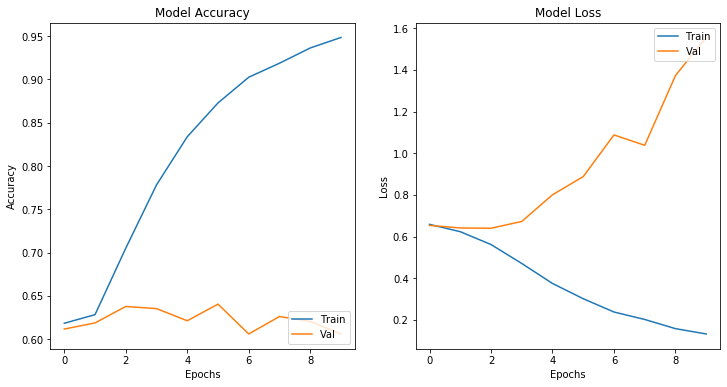

In [85]:
plt.figure(figsize=(12,6))

plt.subplot(121)
plt.plot(history.history["acc"])
plt.plot(history.history["val_acc"])
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Train","Val"], loc="lower right")

plt.subplot(122)
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model Loss")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend(['Train', 'Val'], loc='upper right')

plt.show()

In [86]:
'''Due to the sklearn method to plot not working this method had to be implimented 
inorder to properly plot a confusion matrix'''
def plot_confusion_matrix(cm,target_names,title='Confusion matrix',normalize=False):

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    plt.figure(figsize=(8, 6))
    plt.grid(b=False)
    plt.imshow(cm, interpolation='nearest', cmap="Blues")
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()


Plots a confusion matrix to show were the model predicted incorrectly.

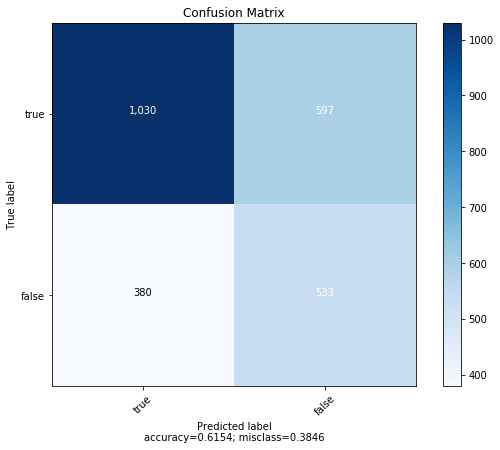

In [87]:
cm = confusion_matrix(test,predict)
plot_confusion_matrix(cm = cm,target_names = ["true","false"],title="Confusion Matrix")

Gets example preictions.

In [88]:
indecies = getRandomIndecies(len(y_predict),n_indecies=10)

Decodes encoded token sequences.

In [89]:
def decode(token_list,token_decode):
    decoded_tokens = list()
    for item in token_list:
        tokens = list()
        for token in item:
            tokens.append(token_decode[token])
        decoded_tokens.append(tokens)
    return decoded_tokens

In [90]:
q_decode = decode(q_x_test,decoder)
p_decode = decode(p_x_test,decoder)

Prints predictions for error analysis.

In [91]:
for index in indecies:
    print(q_decode[index],'\n')
    print(p_decode[index],'\n')
    print(y_test[index], '\n')
    print(y_predict[index], '\n')

['person', 'die', 'from', 'drinking', 'too', 'much', 'water', '%PAD%', '%PAD%', '%PAD%', '%PAD%', '%PAD%', '%PAD%', '%PAD%', '%PAD%'] 

['under', 'normal', 'circumstances', 'accidentally', 'consuming', 'too', 'much', 'water', 'exceptionally', 'rare', 'nearly', 'all', 'deaths', 'related', 'water', 'intoxication', 'normal', 'individuals', 'resulted', 'either', 'from', 'water', 'drinking', 'contests', 'which', 'individuals', 'attempt', 'consume', 'large', 'amounts', 'water', 'or', 'from', 'long', 'bouts', 'exercise', 'during', 'which', 'excessive', 'amounts', 'fluid', 'were', 'consumed', 'addition', 'water', 'cure', 'method', 'torture', 'which', 'victim', 'forced', 'consume', 'excessive', 'amounts', 'water', 'cause', 'water', 'intoxication', '%PAD%', '%PAD%', '%PAD%', '%PAD%', '%PAD%', '%PAD%', '%PAD%', '%PAD%', '%PAD%', '%PAD%', '%PAD%', '%PAD%', '%PAD%', '%PAD%', '%PAD%', '%PAD%', '%PAD%', '%PAD%', '%PAD%', '%PAD%', '%PAD%', '%PAD%', '%PAD%', '%PAD%', '%PAD%', '%PAD%', '%PAD%', '%PAD%',

# 7) Deploy, Monitor, Maintain

## Deploy

Currently, this model is not in a state to be deployed. With better feature engineering or a more relative data set, this model could perform well enough to be deployed through cloud services in order to answer more narrow questions.

## Monitor

In order to monitor our model, we would compare the current dictionaries to the new dictionaires and make changes to improve the accuracy for future questions.

## Maintain

In order to maintain this model, we could update the dictionary to support the majority of words used instead of specifying the dictonary towards our dataset.

# 8) Summary

Our baseline tdifVecotrlizer preformed slightly better than the RNN. The logistic regression baseline had signifigantly less feature engineering and ran much quicker. This could mean a more complex model architecture is needed.The paper that we used as reference delves deeper with the idea that "Exploring the Surprising Difficulty of Natural Yes/No Questions" is a hard topic that is still being worked on. Newer technology allows for attention layers that detect similarities in the question and passage and output a score based on the similarities. With this new technology, we could have improved the validation accuracy based on similar word groupings. Overall, this project has room for improvement in the future with newer versions and more similar datasets. 